# 3-3,高阶API示范

Pytorch没有官方的高阶API，一般需要用户自己实现训练循环、验证循环、和预测循环。

作者通过仿照keras的功能对Pytorch的nn.Module进行了封装，设计了torchkeras.KerasModel类，

实现了 fit, evaluate等方法，相当于用户自定义高阶API。

并示范了用它实现线性回归模型和DNN二分类模型。

torchkeras.KerasModel类看起来非常强大，但实际上它们的源码非常简单，不足200行。
我们在第一章中`一、Pytorch的建模流程`用到的训练代码其实就是torchkeras库的核心源码。



In [1]:
import torch 
import torchkeras 


print("torch.__version__="+torch.__version__) 
print("torchkeras.__version__="+torchkeras.__version__) 

torch.__version__=2.0.1
torchkeras.__version__=3.9.3


### 一，线性回归模型

此范例我们通过使用torchkeras.KerasModel模型接口，实现线性回归模型。

**1，准备数据**

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset

#样本数量
n = 400

# 生成测试用数据集
X = 10*torch.rand([n,2])-5.0  #torch.rand是均匀分布 
w0 = torch.tensor([[2.0],[-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0 + b0 + torch.normal( 0.0,2.0,size = [n,1])  # @表示矩阵乘法,增加正态扰动


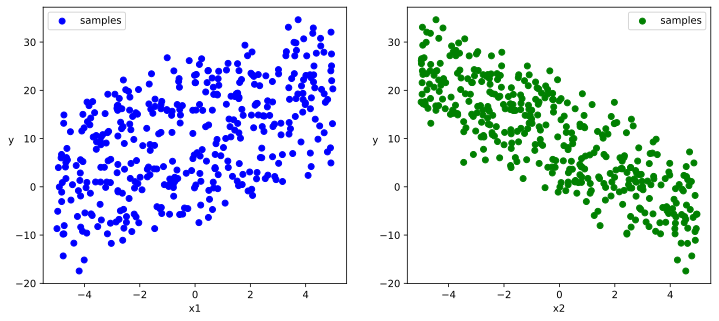

In [4]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()


In [5]:
#构建输入数据管道
ds = TensorDataset(X,Y)
ds_train,ds_val = torch.utils.data.random_split(ds,[int(400*0.7),400-int(400*0.7)])
dl_train = DataLoader(ds_train,batch_size = 16,shuffle=True,num_workers=2)
dl_val = DataLoader(ds_val,batch_size = 16,num_workers=2)

features,labels = next(iter(dl_train))


**2，定义模型**

In [9]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.fc = nn.Linear(2,1)
    
    def forward(self,x):
        return self.fc(x)

net = LinearRegression()


In [10]:
from torchkeras import summary 

summary(net,input_data=features);

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Linear-1                                     [-1, 1]                    3
Total params: 3
Trainable params: 3
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000069
Forward/backward pass size (MB): 0.000008
Params size (MB): 0.000011
Estimated Total Size (MB): 0.000088
--------------------------------------------------------------------------


**3，训练模型**

<<<<<< 🚀 mps is used >>>>>>


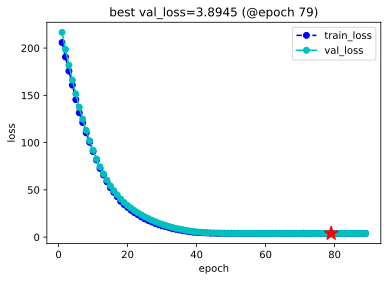

<<<<<< val_loss without improvement in 10 epoch,early stopping >>>>>> 



In [11]:
from torchkeras import KerasModel 

import torchmetrics

net = LinearRegression()
model = KerasModel(net=net,
                   loss_fn = nn.MSELoss(),
                   metrics_dict = {"mae":torchmetrics.MeanAbsoluteError()},
                   optimizer= torch.optim.Adam(net.parameters(),lr = 0.01))

dfhistory = model.fit(train_data=dl_train,
      val_data=dl_val,
      epochs=100,
      ckpt_path='checkpoint',
      patience=10,
      monitor='val_loss',
      mode='min')


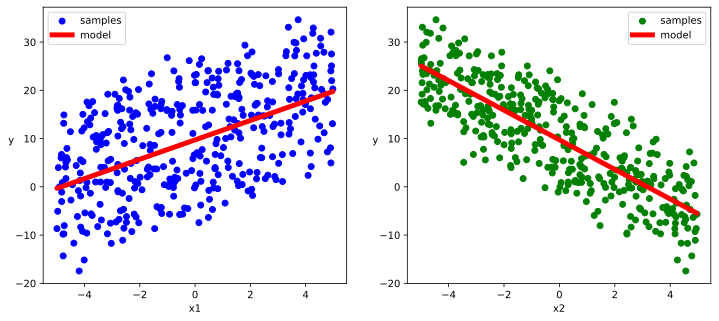

In [12]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = net.state_dict()["fc.weight"],net.state_dict()["fc.bias"]

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0,0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[0,1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()


**4，评估模型**

In [13]:
dfhistory.tail()

,epoch,train_loss,train_mae,lr,val_loss,val_mae
84,85,3.886948,1.602324,0.01,3.927154,1.568657
85,86,3.973511,1.596834,0.01,3.907408,1.565720
86,87,3.984756,1.599551,0.01,3.933845,1.571336
87,88,3.972810,1.605367,0.01,3.983606,1.578675
88,89,3.934518,1.605768,0.01,3.987594,1.580409


In [14]:
# 评估
model.evaluate(dl_val)

100%|████████████████████████████████████| 8/8 [00:01<00:00,  7.51it/s, val_loss=3.89, val_mae=1.56]


{'val_loss': 3.8944740295410156, 'val_mae': 1.5583606958389282}

**5，使用模型**

In [16]:
# 预测
dl = DataLoader(TensorDataset(X))

result = []
with torch.no_grad():
    for batch in dl:
        features = batch[0].to(model.accelerator.device)
        res = net(features)
        result.extend(res.tolist())
result = np.array(result).flatten() 
print(result[:10])

[24.30810547 -0.18447018 10.48405933 10.95958519 20.05254555 25.67943192
 25.41451073 22.11546135  9.20176315 19.23609543]


### 二，DNN二分类模型

**1，准备数据**

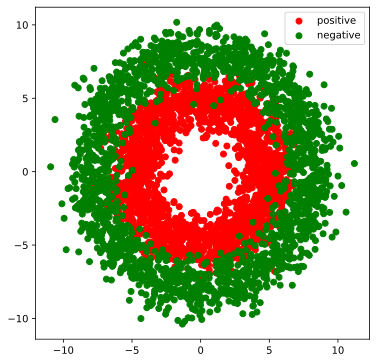

In [17]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torchkeras 
import pytorch_lightning as pl 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1]) 
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n)

#汇总样本
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0],Xp[:,1],c = "r")
plt.scatter(Xn[:,0],Xn[:,1],c = "g")
plt.legend(["positive","negative"]);


In [18]:
ds = TensorDataset(X,Y)

ds_train,ds_val = torch.utils.data.random_split(ds,[int(len(ds)*0.7),len(ds)-int(len(ds)*0.7)])
dl_train = DataLoader(ds_train,batch_size = 100,shuffle=True,num_workers=2)
dl_val = DataLoader(ds_val,batch_size = 100,num_workers=2)

for features,labels in dl_train:
    break 

**2，定义模型**

In [19]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,4)
        self.fc2 = nn.Linear(4,8) 
        self.fc3 = nn.Linear(8,1)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = self.fc3(x)
        return y
    

In [30]:
from torchkeras import KerasModel 
from torchkeras.metrics import Accuracy

net = Net()
loss_fn = nn.BCEWithLogitsLoss()
metric_dict = {"acc":Accuracy()}

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

model = KerasModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metric_dict,
                   optimizer = optimizer
                  )       

from torchkeras import summary
summary(net,input_data=features);


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Linear-1                                     [-1, 4]                   12
Linear-2                                     [-1, 8]                   40
Linear-3                                     [-1, 1]                    9
Total params: 61
Trainable params: 61
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000069
Forward/backward pass size (MB): 0.000099
Params size (MB): 0.000233
Estimated Total Size (MB): 0.000401
--------------------------------------------------------------------------


**3，训练模型**

<<<<<< 🚀 mps is used >>>>>>


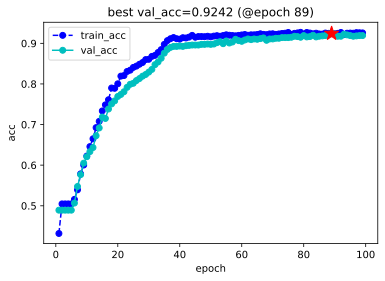

<<<<<< val_acc without improvement in 10 epoch,early stopping >>>>>> 



In [31]:
dfhistory = model.fit(
      train_data=dl_train,
      val_data=dl_val,
      epochs=100,
      ckpt_path='checkpoint',
      patience=10,
      monitor='val_acc',
      mode='max'
)


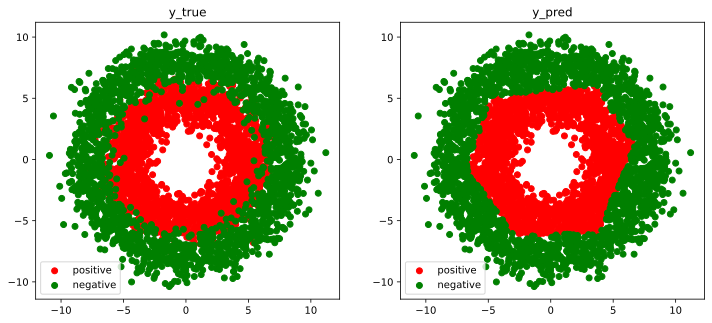

In [32]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(net.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(net.forward(X)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");


**4，评估模型**

In [33]:
model.evaluate(dl_val)

100%|████████████████████████████████| 12/12 [00:01<00:00, 10.94it/s, val_acc=0.924, val_loss=0.202]


{'val_loss': 0.20166969237228236, 'val_acc': 0.9241666793823242}

**5，使用模型**

In [37]:
device = model.accelerator.device 
@torch.no_grad()
def predict(net,dl):
    net.eval()
    result = torch.cat([net.forward(t[0].to(device)) for t in dl])
    return(result.data)

predictions = F.sigmoid(predict(net,dl_val)[:10]) 

In [38]:
predictions 

tensor([[0.3352],
        [0.9824],
        [0.0443],
        [0.9682],
        [0.0016],
        [0.0012],
        [0.9986],
        [0.0016],
        [0.0079],
        [0.0654]], device='mps:0')

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)